In [1]:
import qiskit as qsk, numpy as np, matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp, Statevector, Clifford

In [2]:
def random_thetas(shape: "shape"):
    possible_theta_values = np.pi / 2 * np.arange(4)
    return np.random.choice(possible_theta_values, shape)

def simple_test_circuit(angles: np.ndarray):
    n_qubits = len(angles)
    qc = qsk.QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        qc.rx(angles[i], i)
    return qc

def parameter_shift_rule_gradient(f: "function", angles: np.ndarray[int], *args, **kwargs):
    out = np.empty_like(angles, dtype=complex)
    for i in np.ndindex(angles.shape):
        original_angle = angles[i]  # Will need to be restored at the end of loop
        angles[i] += 1 * np.pi / 2
        f_plus = f(angles, *args, **kwargs)
        angles[i] -= 2 * np.pi / 2
        f_minus = f(angles, *args, **kwargs)
        angles[i] = original_angle
        out[i] = (f_plus - f_minus) / 2
    return out

def empirical_NTK(f: "function", angles: np.ndarray[int], x, y, *args):
    return np.sum(
        parameter_shift_rule_gradient(f, angles, x, *args)
        *
        parameter_shift_rule_gradient(f, angles, y, *args)
    )

def analytic_NTK(f: "function", x, y, angles_shape: tuple[int], n_shots: int, *args):
    return np.mean([
        empirical_NTK(
            f, random_thetas(angles_shape), x, y, *args
        )
        for _ in range(n_shots)
    ])

In [10]:
n_qubits = 5
n_shots = 500

x = 7
y = 0

psi1, psi2 = Statevector.from_int(x, 2**n_qubits), Statevector.from_int(y, 2**n_qubits)
obs = SparsePauliOp.from_sparse_list(
    [
        ("Z", [i], 1) for i in range(n_qubits)
    ],
    num_qubits=n_qubits
)

def evolveSPO(op: SparsePauliOp, other: Clifford) -> SparsePauliOp:
    return SparsePauliOp(
        op.paulis.evolve(other)
    )

def qf(thetas, psi1, op):
    qc = simple_test_circuit(thetas)
    psi1 = psi1.evolve(qc)
    #op = evolveSPO(op, Clifford(qc)) 
    return psi1.expectation_value(op)

analytic_NTK(qf, psi1, psi2, [n_qubits], n_shots, obs)

np.complex128(-0.514+0j)

In [60]:
np.random.seed(42)
initial_state: int = 2
angles = random_thetas(n_qubits)
qc = simple_test_circuit(angles)
print(qc.draw("text"))

O = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1) for i in range(qc.num_qubits)],
    num_qubits= qc.num_qubits
)
print(O)
psi = Statevector.from_int(initial_state, 2**qc.num_qubits)
display(psi.draw("latex"))
psi_evolved = psi.evolve(qc)
display(psi_evolved.draw("latex"))

      ┌───────┐  
q_0: ─┤ Rx(π) ├──
     ┌┴───────┴─┐
q_1: ┤ Rx(3π/2) ├
     └┬───────┬─┘
q_2: ─┤ Rx(0) ├──
      ├───────┤  
q_3: ─┤ Rx(π) ├──
      ├───────┤  
q_4: ─┤ Rx(π) ├──
      └───────┘  
SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [63]:
qc_as_cliff = Clifford(qc)
print(qc_as_cliff)
O_evolved = SparsePauliOp(
    O.paulis.evolve(qc_as_cliff)
)
print("O = \n", O)
print("O_evolved = \n",O_evolved)

result1, result2 = psi_evolved.expectation_value(O), psi.expectation_value(O_evolved)
print(
    result1,
    result2,
    np.isclose(result1, result2)
)

Clifford: Stabilizer = ['-IIIIZ', '+IIIYI', '+IIZII', '-IZIII', '-ZIIII'], Destabilizer = ['+IIIIX', '+IIIXI', '+IIXII', '+IXIII', '+XIIII']
O = 
 SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
O_evolved = 
 SparsePauliOp(['IIIIZ', 'IIIYI', 'IIZII', 'IZIII', 'ZIIII'],
              coeffs=[-1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j])
(-1.9999999999999998+0j) (-2+0j) True


In [62]:
result2

np.complex128(-2+0j)

In [49]:
angles = random_thetas(5)
qc = simple_test_circuit(angles)
#qc.measure_all()
print(qc.draw("text"))


O = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1) for i in range(qc.num_qubits)],
    num_qubits= qc.num_qubits
)
print(O)
psi = Statevector.from_int(1, 2**qc.num_qubits)
#psi = Statevector.from_label("00010")
display(psi.draw("latex"))
psi = psi.evolve(qc)
display(psi.draw("latex"))

      ┌───────┐  
q_0: ─┤ Rx(π) ├──
     ┌┴───────┴─┐
q_1: ┤ Rx(3π/2) ├
     └┬───────┬─┘
q_2: ─┤ Rx(0) ├──
      ├───────┤  
q_3: ─┤ Rx(π) ├──
      ├───────┤  
q_4: ─┤ Rx(0) ├──
      └───────┘  
SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [58]:
psi.expectation_value(O)

np.complex128(1.9999999999999998+0j)

In [54]:
psi2 = Statevector([
    1,2,3,4
])

display(psi2.draw("latex"))

<IPython.core.display.Latex object>

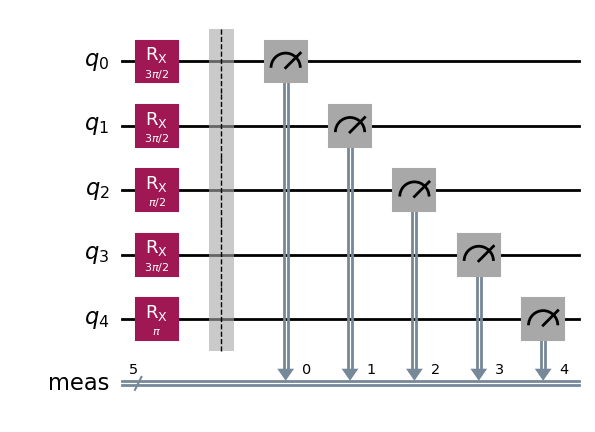

In [13]:
qc.draw("mpl")

In [ ]:
qc = qsk.QuantumCircuit(10)




qc = qsk.quantum_info.Clifford(qc)
qc.to_circuit().draw("mpl")

CircuitError: "Invalid param type <class 'numpy.ndarray'> for gate rx."

In [26]:
len(qc.to_dict()['destabilizer'])

10